#时间序列预测
本教程是使用递归神经网络（RNN）进行时间序列预测的简介。这包括两个部分：首先，您将预测单变量时间序列，然后将预测多变量时间序列。

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function,unicode_literals
import tensorflow as tf

import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


In [0]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

##天气数据集
本教程使用[[由马克斯·普朗克生物地球化学研究所](https://www.bgc-jena.mpg.de/)记录的[天气时间序列数据集](https://www.bgc-jena.mpg.de/wetter/)。

该数据集包含14个不同的特征，例如气温，大气压力和湿度。从2003年开始，每10分钟收集一次。为了提高效率，您将仅使用2009年至2016年之间收集的数据。数据集的这一部分由FrançoisChollet为他的《Python深度学习》准备。

In [4]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True
)
csv_path,_ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 0s 0us/step


In [0]:
df = pd.read_csv(csv_path)

In [6]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


如上所示，每10分钟记录一次观察值。这意味着在一个小时内，您将有6个观测值。同样，一天将包含144（6x24）次观察。

给定一个特定的时间，假设您要预测未来6小时的温度。为了做出此预测，您选择使用5天的观察时间。因此，您将创建一个包含最后720（5x144）个观测值的窗口以训练模型。许多这样的配置都是可能的，这使该数据集成为一个很好的实验对象。

下面的函数返回上述时间窗以供模型训练。该参数`history_size`是过去信息窗口的大小。这`target_size`是模型需要学习预测的未来时间。该`target_size`是需要被预测的标签。

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data =[]
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices =range(i - history_size,i)
    # Reshape data from (history_size,) to (history_size,1)
    data.append(np.reshape(dataset[indices],(history_size,1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

在以下两个教程中，数据的前300,000行将是训练数据集，而其余将是验证数据集。总计约2100天的训练数据。

In [0]:
TRAIN_SPLIT = 300000

设置种子以确保可重复性。

In [0]:
tf.random.set_seed(13)

###第1部分：预测单变量时间序列
首先，您将仅使用一个特征（温度）训练模型，并在将来使用该模型为该值做出预测。

首先，我们仅从数据集中提取温度。

In [10]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

让我们观察一下这些数据随时间变化的样子。

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9104ab2a90>],
      dtype=object)

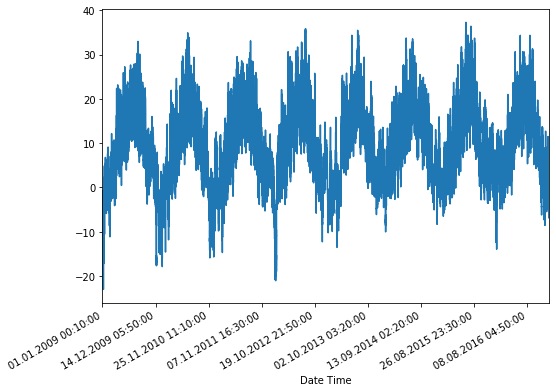

In [11]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

在训练神经网络之前缩放特征很重要。标准化是通过减去平均值并除以每个特征的标准偏差来进行此缩放的一种常见方法。您还可以使用一种`tf.keras.utils.normalize`将值重新缩放到[0,1]范围内的方法。

>注意：均值和标准差只能使用训练数据来计算。

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

让我们标准化数据。

In [0]:
uni_data = (uni_data - uni_train_mean)/uni_train_std

现在让我们为单变量模型创建数据。对于第1部分，将为模型提供最后记录的20个温度观测值，并且需要学习预测下一时间步长的温度。

In [0]:
univariate_past_history = 20
univariate_future_target = 20

x_train_uni, y_train_uni = univariate_data(uni_data,0,TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT,None,
                                       univariate_past_history,
                                       univariate_future_target)

这就是`univariate_data`函数返回的内容。

In [16]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1609193582558586


现在已经创建了数据，让我们看一个例子。提供给网络的信息以蓝色表示，并且必须预测红十字处的值。

In [0]:
def create_time_steps(length):
  return list(range(-length,0))

In [0]:
def show_plot(plot_data, delta,title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-','rx','go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta 
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i :
      plt.plot(future,plot_data[i],marker[i],markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps,plot_data[i].flatten(),marker[i],label=labels[i])

  plt.legend()
  plt.xlim([time_steps[0],(future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

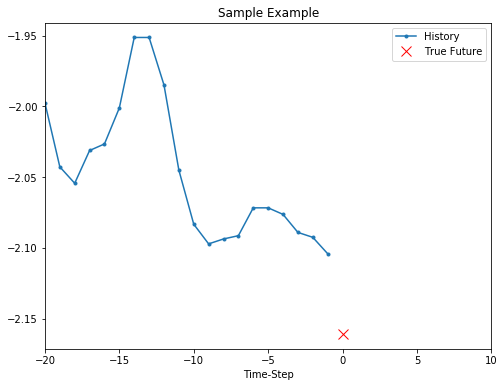

In [19]:
show_plot([x_train_uni[0],y_train_uni[0]],0,'Sample Example')

###基准线
在继续训练模型之前，让我们首先设置一个简单的基准。在给定输入点的情况下，基线方法将查看所有历史记录，并预测下一个点是最近20次观察的平均值。

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

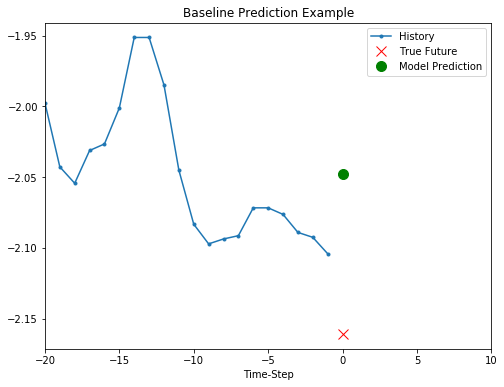

In [22]:
show_plot([x_train_uni[0],y_train_uni[0],baseline(x_train_uni[0])],0,
          'Baseline Prediction Example')

让我们看看您是否可以使用递归神经网络超越这一基线。

###递归神经网络
递归神经网络（RNN）是一种非常适合时间序列数据的神经网络。RNN分步处理时间序列，并保持内部状态，以汇总到目前为止所看到的信息。有关更多详细信息，请阅读RNN教程。在本教程中，您将使用一个称为RNN的专用RNN层（LSTM）

现在让我们`tf.data`用于随机整理，批处理和缓存数据集。

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni,y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni,y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

以下可视化效果应有助于您理解批处理后数据的表示方式。
![](https://www.tensorflow.org/tutorials/structured_data/images/time_series.png?hl=zh_cn)

您将看到LSTM需要给出的数据的输入形状。

In [0]:
simple_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(8,input_shape=x_train_uni.shape[-2:]),
  tf.keras.layers.Dense(1)
])
simple_lstm_model.compile(optimizer='adam',loss='mae')

让我们做一个样本预测，以检查模型的输出。

In [25]:
for x, y in val_univariate.take(1):
  print(simple_lstm_model.predict(x).shape)

(256, 1)


让我们现在训练模型。由于数据集的大小很大，为了节省时间，每个纪元只能运行200步，而不是像通常那样运行完整的训练数据。

In [26]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate,epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate,
                      validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 0.4916 - val_loss: 0.2871
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2924 - val_loss: 0.2021
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2781 - val_loss: 0.1963
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2509 - val_loss: 0.1871
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2102 - val_loss: 0.1828
Epoch 6/10
168/200 [========================>.....] - ETA: 0s - loss: 0.2312WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2000 batches). You may need to use the repeat() function when building your dataset.


###使用简单的LSTM模型进行预测
既然您已经训练了简单的LSTM，让我们尝试做一些预测。

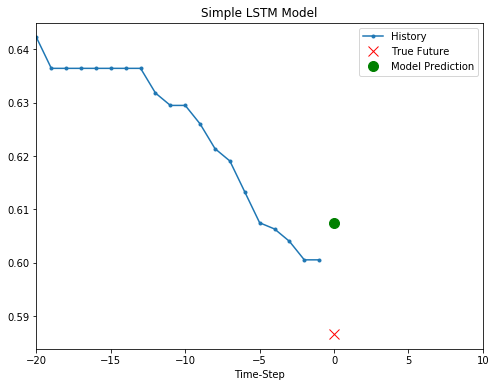

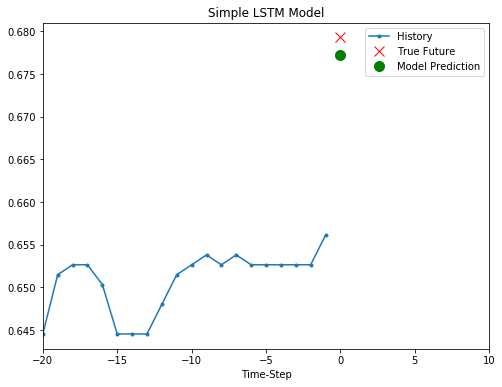

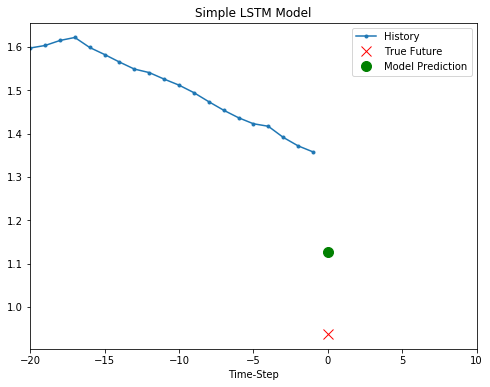

In [29]:
for x,y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(),y[0].numpy(),
                    simple_lstm_model.predict(x)[0]],0,
                   'Simple LSTM Model')
  plot.show()

这看起来比基线更好。既然您已经了解了基础知识，那么让我们继续第二部分，在这里您将使用多元时间序列。

## 第2部分：预测多元时间序列
原始数据集包含十四个特征。为简单起见，本节仅考虑原始十四个中的三个。使用的功能是气温，大气压力和空气密度。

要使用更多功能，请将其名称添加到此列表中。

In [0]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [31]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


让我们看一下这些功能在时间上的变化。

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9101092ef0>,
      dtype=object)

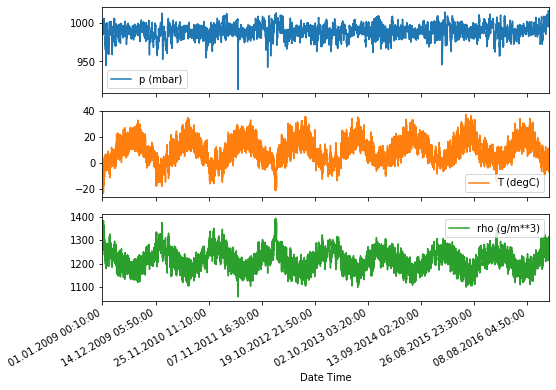

In [32]:
features.plot(subplots=True)

如前所述，第一步将是使用训练数据的均值和标准差对数据集进行标准化。

In [0]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [0]:
dataset = (dataset - data_mean)/data_std

###单步模型
在一步设置中，模型将根据提供的一些历史记录来学习预测未来的单个点。

下面的函数执行与下面相同的加窗任务，但是，这里它根据给定的步长对过去的观察进行采样。

In [0]:
def multivariate_data(dataset, target, start_index, end_index,history_size,
                      target_size,step, single_step = False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i - history_size,i,step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data),np.array(labels)

在本教程中，将向网络显示最近五（5）天的数据，即每小时采样720个观测值。每隔一小时进行一次采样，因为预计60分钟内不会发生剧烈变化。因此，120次观察代表最近五天的历史。对于单步预测模型，数据点的标签是未来12小时的温度。为了为此创建标签，使用72（12 * 6）次观察后的温度。

In [0]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:,1],0,
                                                   TRAIN_SPLIT,past_history,
                                                   future_target,STEP,
                                                   single_step=True)
x_val_single,y_val_single = multivariate_data(dataset, dataset[:,1],
                                              TRAIN_SPLIT,None,past_history,
                                              future_target, STEP,
                                              single_step=True)

In [37]:
#让我们看一个数据点。
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

让我们看看样本预测。

In [56]:
for x,y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [57]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 18ms/step - loss: 0.3360 - val_loss: 0.2671
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2653 - val_loss: 0.2473
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2598 - val_loss: 0.2376
Epoch 4/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2596 - val_loss: 0.2415
Epoch 5/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2282 - val_loss: 0.2426
Epoch 6/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2402 - val_loss: 0.2509
Epoch 7/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2413 - val_loss: 0.2531
Epoch 8/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2428 - val_loss: 0.2419
Epoch 9/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2448 - val_loss: 0.2435
Epoch 10/10
200/200 [===========================

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

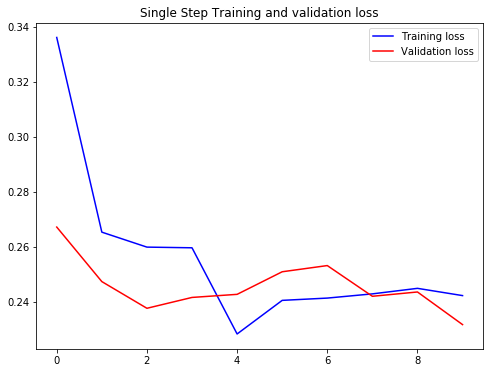

In [59]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

###预测未来的一步
现在已经对模型进行了训练，让我们进行一些样本预测。该模型具有每小时过去5天采样的三个要素的历史记录（120个数据点），因为目标是预测温度，所以该图仅显示过去的温度。预测是在未来一天进行的（因此，历史记录和预测之间存在差距）。

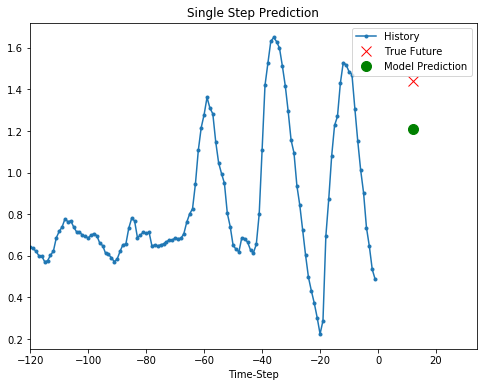

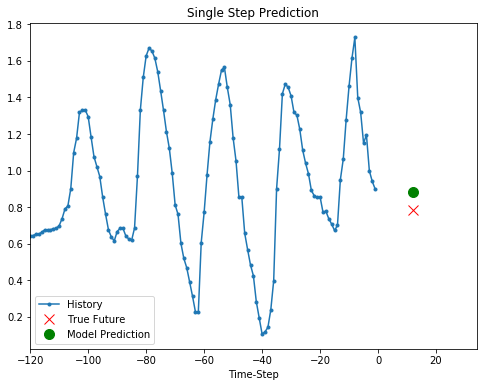

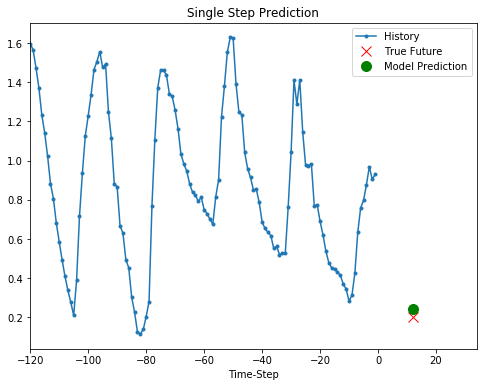

In [60]:
for x,y in val_data_single.take(3):
  plot = show_plot([x[0][:,1].numpy(),y[0].numpy(),
                    single_step_model.predict(x)[0]],12,
                   'Single Step Prediction')
  plot.show()

###多步模型
在多步骤预测模型中，给定过去的历史，该模型需要学习预测一系列未来值。因此，与仅预测单个未来点的单步模型不同，多步模型预测未来的序列。

对于多步骤模型，训练数据再次包括每小时采样的过去五天的记录。但是，这里的模型需要学习预测接下来12小时的温度。由于每10分钟进行一次反驳，因此输出为72个预测。对于此任务，需要相应地准备数据集，因此第一步只是再次创建它，但使用不同的目标窗口。

In [0]:
future_target = 72
x_train_multi,y_train_multi = multivariate_data(dataset,dataset[:,1],0,
                                                TRAIN_SPLIT,past_history,
                                                future_target,STEP)
x_val_multi,y_val_multi = multivariate_data(dataset,dataset[:,1],
                                            TRAIN_SPLIT,None,past_history,
                                            future_target,STEP)

让我们检查一个样本数据点。


In [62]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi,y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi,y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

绘制样本数据点。


In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

在此图和后续类似图中，每小时都会采样历史记录和将来的数据。

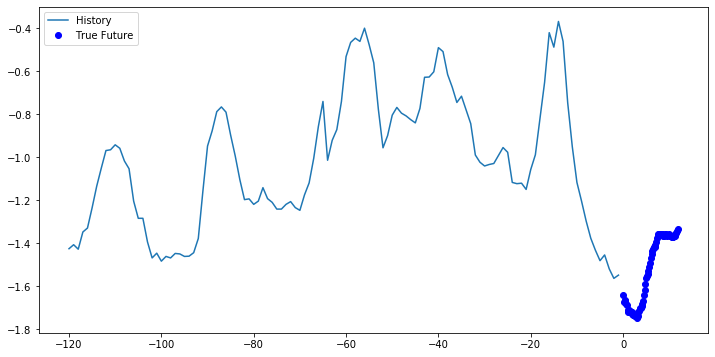

In [67]:
for x,y in train_data_multi.take(1):
  multi_step_plot(x[0],y[0],np.array([0]))

由于此处的任务比先前的任务要复杂一些，因此该模型现在由两个LSTM层组成。最后，由于进行了72个预测，因此密集层将输出72个预测。

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16,activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),loss='mae')

让我们看看模型在训练之前如何预测。

In [69]:
for x,y in val_data_multi.take(1):
  print(multi_step_model.predict(x).shape)

(256, 72)


In [71]:
multi_step_history = multi_step_model.fit(train_data_multi,epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 26s 131ms/step - loss: 35.4585 - val_loss: 0.3044
Epoch 2/10
200/200 [==============================] - 24s 118ms/step - loss: 0.3488 - val_loss: 0.2773
Epoch 3/10
200/200 [==============================] - 24s 118ms/step - loss: 0.3324 - val_loss: 0.2456
Epoch 4/10
200/200 [==============================] - 24s 119ms/step - loss: 0.2449 - val_loss: 0.2111
Epoch 5/10
200/200 [==============================] - 24s 120ms/step - loss: 0.1995 - val_loss: 0.2075
Epoch 6/10
200/200 [==============================] - 24s 121ms/step - loss: 0.2075 - val_loss: 0.2107
Epoch 7/10
200/200 [==============================] - 25s 123ms/step - loss: 0.1991 - val_loss: 0.2078
Epoch 8/10
200/200 [==============================] - 24s 120ms/step - loss: 0.1957 - val_loss: 0.1971
Epoch 9/10
200/200 [==============================] - 24s 120ms/step - loss: 0.1984 - val_loss: 0.1929
Epoch 10/10
200/200 [========

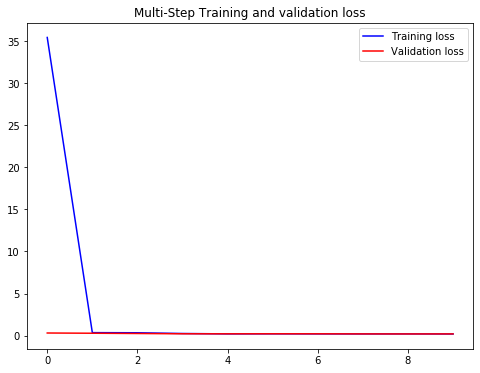

In [72]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

###预测多步骤的未来
现在让我们来看看您的网络在预测未来方面的学习情况

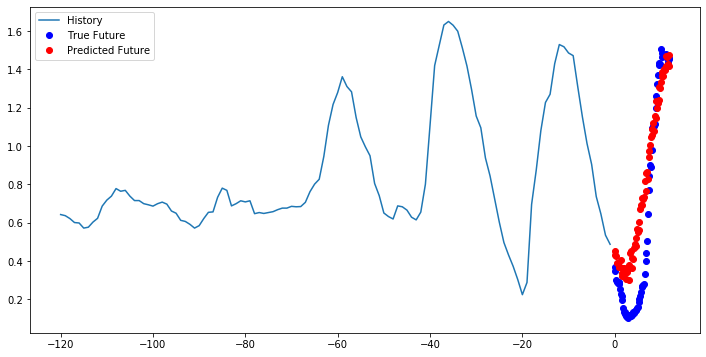

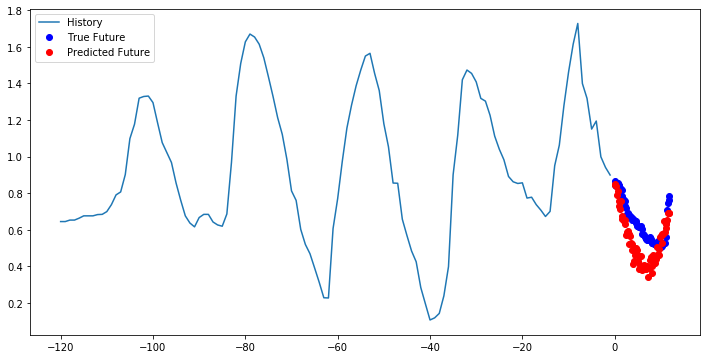

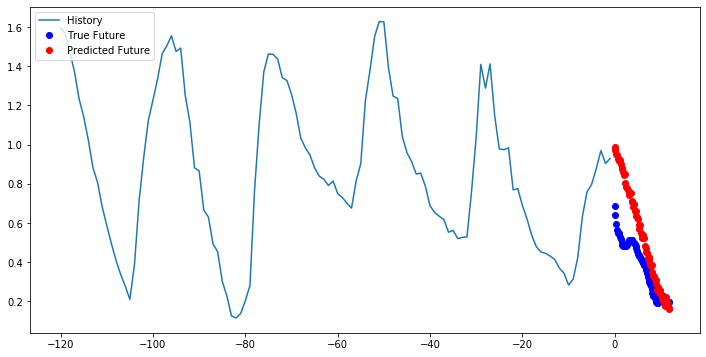

In [73]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])